# Convolutional Neural Networks with Tensorflow

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from time import time
from IPython.display import Image
import math
from addutils import css_notebook
from scipy import ndimage
from skimage import data
from utilities import cifar10
import matplotlib.pyplot as plt
import os
import pickle
css_notebook()

In [3]:
import bokeh.plotting as bk
from bokeh.io import push_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
bk.output_notebook()

Loading BokehJS ...

## 1 Convolutional Neural Network

Convolutional Neural Networks have gained much attention in the past few years, because they work very well in image processing, but nowadays are applyed to many Deep Learning tasks.

The fundamental difference between fully connected and convolutional neural networks is the connection between consecutive layers. In fully connected network each neuron is connected to all neuron in the previous layer. We sa that in previous notebook. In a convolutional layer instead each neuron is connected to a (typically small) number of neurons in the previous layer. Furthermore all neurons in the same layer are coonected to the previous layer in the same way, they have the exact same way, with the same weights. This operation is known as convolution and in a nutshell it means applying a small filter across an image.

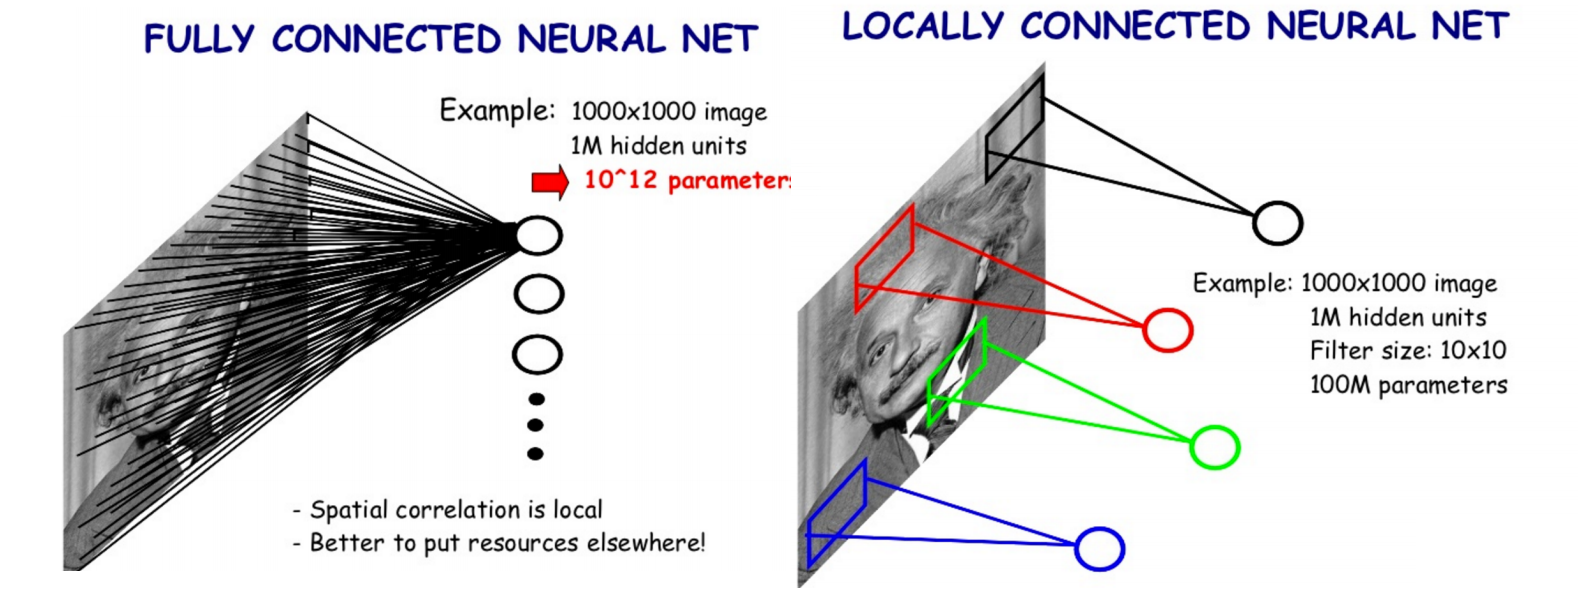

In [4]:
Image('images/WeightSharing.png')

**TODO** motivazioni delle convolutional (invariance, astrazione)

Convolutional neural networks use three basic ideas: **local receptive fields**, **shared weights**, and **pooling**. Let's look at each of these ideas in turn. 

#### 1.1 Local Receptive Fields and Shared Weights

In the fully-connected layers shown earlier, the inputs were depicted as a vertical line of neurons. In a convolutional net, it'll help to think instead of the inputs as a 28×28 square of neurons, whose values correspond to the 28×28 pixel intensities we're using as inputs:

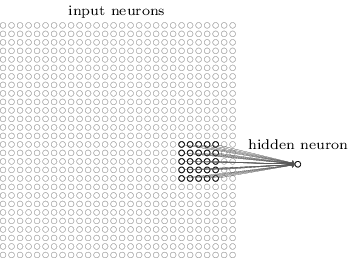

In [5]:
Image('images/receptive.png')

We will connect the input pixels to a layer of hidden neurons. But we don't connect every input pixel to every hidden neuron. Instead, we only make connections in small, localized regions of the input image.

To be more precise, each neuron in the first hidden layer will be connected to a small region of the input neurons, say, for example, a 5×5 region, corresponding to 25 input pixels. That region in the input image is called the **local receptive field** for the hidden neuron. I've shown the local receptive field being moved by one pixel at a time. In fact, sometimes a different stride length is used. For instance, we might move the local receptive field 2 pixels to the right (or down), in which case we'd say a stride length of 2 is used. 

Each hidden neuron has a bias and 5×5 weights connected to its local receptive field. What I did not yet mention is that we're going to use the same weights and bias for each of the 24×24 hidden neurons. This means that all the neurons in the first hidden layer detect exactly the same feature just at different locations in the input image. They **Share weights and biases**. For this reason, we sometimes call the map from the input layer to the hidden layer a **feature map**. We call the weights defining the feature map the shared weights. And we call the bias defining the feature map in this way the shared bias. The shared weights and bias are often said to define a kernel or filter.

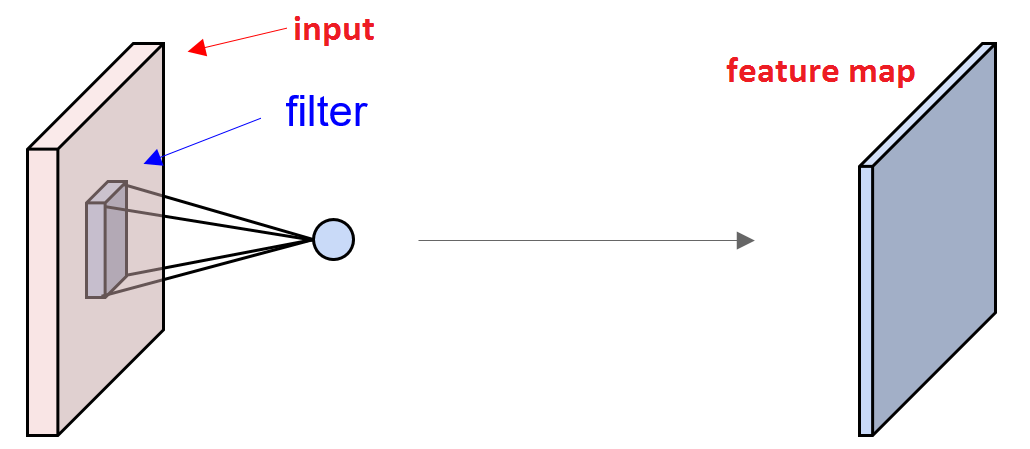

In [6]:
 Image('images/feature_map.png', width=700, height=700)

Why is a filter useful? Historically

Let's see how filter works. We will implement two basic filters, a gaussian filter and a gabor filter.

In [7]:
ksize = 100
x = np.linspace(-3, 3, ksize)
y = np.exp(-np.power(x - 0, 2.) / (2 * np.power(1, 2.)))
fig = bk.figure(plot_width=400, plot_height=250, title=None)
fig.line(x, y)
bk.show(fig)

Now we can create a two-dimensional filter by multiplying a column vector gaussian by a row vector gaussian to create a matrix, that will be our filter.

In [8]:
gaussian_kernel = np.dot(np.atleast_2d(y).T, np.atleast_2d(y))
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[gaussian_kernel], x=0, y=0, dw=1, dh=1, palette="Plasma256")
bk.show(fig)
print(gaussian_kernel.shape)

(100, 100)


In [9]:
img = data.camera().astype(np.float32)
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[np.flip(img, axis=0)], x=0, y=0, dw=1, dh=1, palette="Greys256")
bk.show(fig)
print(img.shape)

(512, 512)


In [10]:
convolved = ndimage.convolve(img, gaussian_kernel, mode='constant', cval=0.0)
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[np.flip(convolved, axis=0)], x=0, y=0, dw=1, dh=1, palette="Greys256")
bk.show(fig)

In [11]:
x = np.linspace(-3, 3, ksize)
y = np.sin(x)
fig = bk.figure(plot_width=400, plot_height=250, title=None)
fig.line(x, y)
bk.show(fig)

In [12]:
ones = np.ones((1, ksize))
wave = np.dot(np.atleast_2d(y).T, ones)
gabor_filter = np.dot(wave, gaussian_kernel)
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[gabor_filter], x=0, y=0, dw=1, dh=1, palette="Plasma256")
bk.show(fig)
print(gaussian_kernel.shape)

(100, 100)


In [13]:
convolved = ndimage.convolve(img, gabor_filter, mode='constant', cval=0.0)
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[np.flip(convolved, axis=0)], x=0, y=0, dw=1, dh=1, palette="Greys256")
bk.show(fig)

A big advantage of sharing weights and biases is that it greatly reduces the number of parameters involved in a convolutional network. For each feature map we need 25=5×5 shared weights, plus a single shared bias. So each feature map requires 26 parameters. If we have 32 feature maps that's a total of 32×26=832 parameters defining the convolutional layer. By comparison, suppose we had a fully connected first layer, with 784=28×28 input neurons, and a relatively modest 32 hidden neurons, as we used in many of the examples earlier in the book. That's a total of 784×32 weights, plus an extra 32 biases, for a total of 25,088 parameters. In other words, the fully-connected layer would have more than 30 times as many parameters as the convolutional layer.

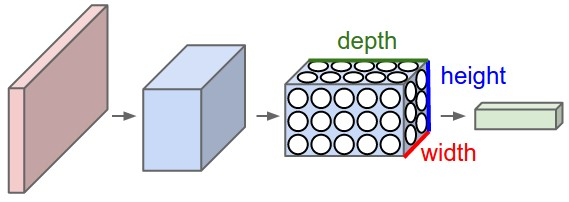

In [14]:
Image('images/cnn.jpeg')

#### 1.2 Pooling layers

In addition to the convolutional layers just described, convolutional neural networks also contain pooling layers. Pooling layers are usually used immediately after convolutional layers. What the pooling layers do is simplify the information in the output from the convolutional layer. Pool layers perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [14x14x32].

Max pooling outputs the maximum of the input in each region of a predefined size (here 2×2). The stride argument controls by how much we slide the pooling grids across the picture. Setting the pooling to a 2×2 grid with strides equal 2 means that the output of the pooling will be exactly one-half of the height and width of the original, and in total one-quarter of the size.

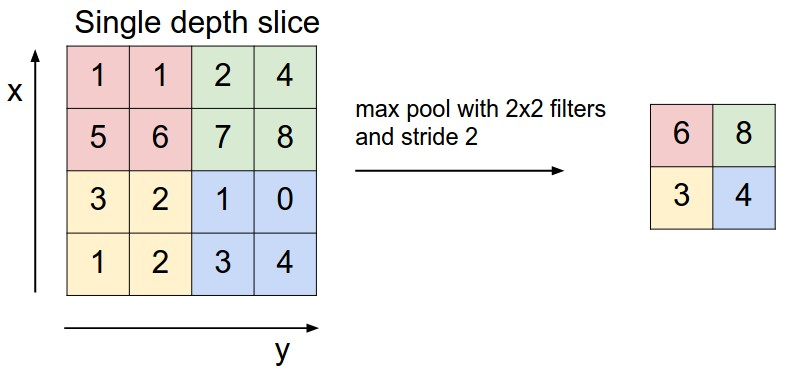

In [15]:
Image('images/maxpool.jpeg', width=600, height=600)

The main motivations for this function are both technical and theoretical. For the technical aspect, pooling reduces the size of the data to be processed and in turn it reduces the number of overall parameters in the model, especially if we use fully connected layers after the convolutional ones. The theoretical aspect instead is that we would like the feature maps not to care about small changes in position in an image. For instance, a feature looking for eyes in the top-right part of an image should not change too much if we move the camera a bit to the right when taking the picture, moving the eyes slightly to the center of the image. Aggregating the feature maps spatially allows the model to overcome such variability, capturing some form of invariance.

## 2 CNN for MNIST

### 2.1 The Data

In [16]:
mnist = input_data.read_data_sets('example_data/MNIST_data', one_hot=True)

Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

### 2.2 The Model

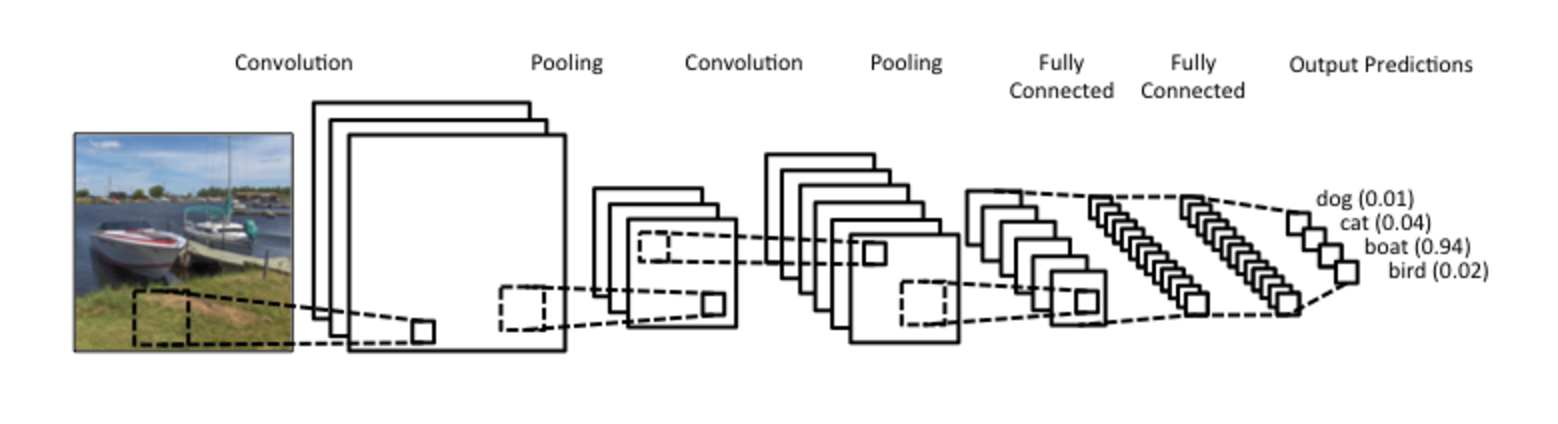

In [18]:
Image('images/tf_mnist.png')

The following code defines the usual placeholder for the input examples and associated labels, as well as two helper functions to construct weight variables.

In [19]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [20]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [21]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


Reshape of the input so it resemble a 2D image.

In [22]:
x_image = tf.reshape(x, [-1,28,28,1])

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolutional will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel. 

In [23]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.

In [24]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [25]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Last but not least, a fully connected layer that is able to combine previous layers

In [26]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

One thing to mention is regularization we applied dropout to prevent overfitting. 

In [27]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Last stage compute probability and assign to each example a class.

In [28]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [29]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 2.3 Training and Evaluation

In [30]:
sess = tf.InteractiveSession()

In [31]:
STEPS = 1000
BATCH_SIZE = 128

In [32]:
sess.run(tf.global_variables_initializer())

for i in range(STEPS):
    batch = mnist.train.next_batch(BATCH_SIZE)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], 
                                                  y_: batch[1], 
                                                  keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.101562
step 100, training accuracy 0.851562
step 200, training accuracy 0.929688
step 300, training accuracy 0.945312
step 400, training accuracy 0.976562
step 500, training accuracy 0.945312
step 600, training accuracy 0.960938
step 700, training accuracy 0.953125
step 800, training accuracy 0.96875
step 900, training accuracy 0.984375


In [33]:
print('test accuracy {}'.format(accuracy.eval(feed_dict={x: mnist.test.images, 
                                                  y_: mnist.test.labels, 
                                                  keep_prob: 1.0})))

test accuracy 0.9720001220703125


In [34]:
sess.close()

## 3 CIFAR 10

CIFAR10 is another dataset used to benchmarking computer vision and machine learning algorithms. CIFAR10 is a set of 60,000 color images of size 32×32 pixels, each belonging to one of ten categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Unlike MNIST the images are RGB. We are going to use an utility function to download the cifare dataset. The dataset is approximately 170 MByte.

In [35]:
cifar10.data_path = "example_data/CIFAR-10/"
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [36]:
class_names = cifar10.load_class_names()
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: example_data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: example_data/CIFAR-10/cifar-10-batches-py/test_batch


In [37]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [38]:
print("Training set: {}".format(len(images_train)))
print("Test set: {}".format(len(images_test)))

Training set: 50000
Test set: 10000


This is an helper function for taking random batches from the training set.

In [39]:
def random_batch(batch_size):
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [40]:
def plot_images(images, cls_true, cls_pred=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=.6, wspace=.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, :])    
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
  
    plt.show()

Here we have an example of a 9 images sampled from the training set, with corresponding label.

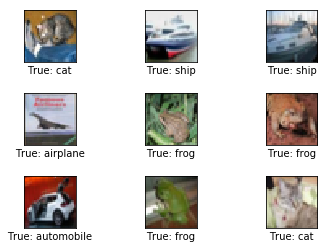

In [41]:
# Get the first images from the test-set.
images = images_test[0:9]
# Get the true classes for those images.
cls_true = cls_test[0:9]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [42]:
def conv_layer(x, shape):
    W_conv = weight_variable(shape)
    b_conv = bias_variable([shape[-1]])
    return tf.nn.relu(conv2d(x, W_conv) + b_conv)

In [43]:
def full_layer(h, shape):
    W_fc = weight_variable(shape)
    b_fc = bias_variable([shape[-1]])

    h_flat = tf.reshape(h, [-1, shape[0]])
    return tf.matmul(h_flat, W_fc) + b_fc

In [44]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

full_1 = tf.nn.relu(full_layer(conv2_flat, [8 * 8 * 64, 256]))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)
full_2 = tf.nn.relu(full_layer(full1_drop, [256, 128]))

y_conv = full_layer(full_2, [128, 10])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, 
                                                                       labels=y_))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy, global_step=global_step)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

In [45]:
def optimize(sess, steps, batch_size, save_dir='temp/cifar_1'):
    save_path = os.path.join(save_dir, 'checkpoint')
    try:
        print("Trying to restore last checkpoint")
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
        saver.restore(sess, save_path=last_chk_path)
        print("Restored checkpoint from:", last_chk_path)
    except:
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())   
        
    for i in range(steps):
        batch = random_batch(batch_size)
        global_i, _ = sess.run([global_step, train_step], feed_dict={x: batch[0], 
                                                                     y_: batch[1], 
                                                                     keep_prob: 0.5})
        if (global_i % 1000 == 0)  or (i == steps - 1):
            train_accuracy = sess.run(accuracy, feed_dict={x:batch[0],
                                                           y_: batch[1],
                                                           keep_prob: 1.0})
            print("step {}, training accuracy {}".format(global_i, train_accuracy))
            saver.save(sess, save_path=save_path, global_step=global_step)
            print("saved checkpoint")

    acc = sess.run(accuracy, feed_dict={x: images_test, y_: labels_test, keep_prob: 1.0})
    print('test accuracy {}'.format(acc))

In [46]:
STEPS = 1000
BATCH_SIZE = 128

In [47]:
with tf.Session() as sess:
    optimize(sess, STEPS, BATCH_SIZE)

Trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.
step 1000, training accuracy 0.609375
saved checkpoint
test accuracy 0.5838999152183533


In [55]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv3 = conv_layer(conv2_pool, shape=[5, 5, 64, 128])
conv3_pool = max_pool_2x2(conv3)
conv3_flat = tf.reshape(conv3_pool, [-1, 4 * 4 * 128])

full_1 = tf.nn.relu(full_layer(conv3_flat, [4 * 4 * 128, 256]))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)
full_2 = tf.nn.relu(full_layer(full1_drop, [256, 128]))

y_conv = full_layer(full_2, [128, 10])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, 
                                                                       labels=y_))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy, global_step=global_step)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

In [57]:
with tf.Session() as sess:
    optimize(sess, STEPS, BATCH_SIZE, save_dir='temp/cifar_2')

Trying to restore last checkpoint
INFO:tensorflow:Restoring parameters from temp/cifar_2/checkpoint-1000
Restored checkpoint from: temp/cifar_2/checkpoint-1000
step 2000, training accuracy 0.7578125
saved checkpoint
test accuracy 0.6534999012947083


---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.